In [7]:
from google.colab import drive
import os

# 1️⃣ Google Drive
drive.mount('/content/drive')

MessageError: Error: credential propagation was unsuccessful

In [2]:
import wandb

In [24]:
!pip install plotly

In [25]:
import plotly.graph_objects as go

In [3]:
wandb.login()

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: birdyyybai (birdyyybai-university-of-michigan) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [4]:
import math
import inspect
from dataclasses import dataclass
import numpy as np
from tqdm import tqdm

import torch
import torch.nn as nn
from torch.nn import functional as F

In [5]:
vocab = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '=', '+', '&', '*']
device = 'cuda' if torch.cuda.is_available() else 'cpu'
padding_token_index = 13
end_token_index = 12

In [6]:
# create a mapping from chars to ints
stoi = {ch:i for i, ch in enumerate(vocab)}
itos = {i:ch for i, ch in enumerate(vocab)}
encode = lambda s:[stoi[c] for c in s] # encoder: take a string, output a list of ints
decode = lambda l: ''.join([itos[i] for i in l]) # decoder: take a list of ints, output a string

print(encode("1+2=3&"))
print(decode(encode("1+2=3&")))

[1, 11, 2, 10, 3, 12]
1+2=3&


In [7]:
# train test split
train_set_1 = np.random.choice(np.arange(10), 8, replace=False)
train_set_2 = np.random.choice(np.arange(10, 100), 72, replace=False)
train_set_3 = np.random.choice(np.arange(100, 1000), 720, replace=False)
test_1 = np.setdiff1d(np.arange(10), train_set_1)
test_2 = np.setdiff1d(np.arange(10, 100), train_set_2)
test_3 = np.setdiff1d(np.arange(100, 1000), train_set_3)
test_12 = np.concatenate([test_1, test_2])
test = np.concatenate([test_1, test_2, test_3])
print(np.sort(train_set_1))
print(np.sort(train_set_2))
print(np.sort(test_1))
print(np.sort(test_2))
print(np.sort(test))

[0 1 2 4 5 6 8 9]
[10 11 12 13 14 15 16 17 18 19 21 22 23 24 25 26 27 28 30 31 33 34 35 36
 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 58 60 63 64 65
 66 68 69 70 71 74 77 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 98 99]
[3 7]
[20 29 32 37 57 59 61 62 67 72 73 75 76 78 79 80 96 97]
[  3   7  20  29  32  37  57  59  61  62  67  72  73  75  76  78  79  80
  96  97 102 107 118 121 125 130 145 146 151 152 154 161 165 169 171 180
 192 193 197 198 199 200 204 207 208 210 218 219 241 254 268 284 294 295
 296 299 303 306 308 317 318 319 327 329 340 341 342 343 348 365 366 373
 377 381 386 396 399 401 407 408 412 417 422 424 427 428 438 443 455 456
 459 468 474 477 496 514 520 526 533 534 536 538 547 553 555 558 559 564
 572 575 582 585 593 594 599 601 608 611 620 622 624 628 635 638 639 647
 650 652 654 655 658 659 660 667 685 690 705 707 715 716 723 724 726 728
 744 749 752 755 759 764 765 766 771 772 776 778 783 785 786 793 803 813
 824 826 838 839 840 841 844 845 862 865 87

In [8]:
def get_batch(phase=None, batch_size=32, block_size=15, mode='train', train_set_1=train_set_1, train_set_2=train_set_2, train_set_3=train_set_3, test=test):

    def sample_from_arrays(one_digit_array, two_digit_array, three_digit_array,
                       phase):
      # stratified sampling
        total_num_in_set = 1000
        if phase == 1:
          sampled_one = np.random.choice(one_digit_array, int(total_num_in_set*1), replace=True)
          sampled_two = np.random.choice(two_digit_array, int(total_num_in_set*0), replace=True)
          sampled_three = np.random.choice(three_digit_array, int(total_num_in_set*0), replace=True)
        elif phase == 2:
          sampled_one = np.random.choice(one_digit_array, int(total_num_in_set*0.3), replace=True)
          sampled_two = np.random.choice(two_digit_array, int(total_num_in_set*0.7), replace=True)
          sampled_three = np.random.choice(three_digit_array, int(total_num_in_set*0), replace=True)
        elif phase == 3:
          sampled_one = np.random.choice(one_digit_array, int(total_num_in_set*0.15), replace=True)
          sampled_two = np.random.choice(two_digit_array, int(total_num_in_set*0.2), replace=True)
          sampled_three = np.random.choice(three_digit_array, int(total_num_in_set*0.65), replace=True)
        # Combine all sampled numbers into one dataset
        new_dataset = np.concatenate([sampled_one, sampled_two, sampled_three])

        return new_dataset


    if mode == 'train':
      sampled_set = sample_from_arrays(train_set_1, train_set_2, train_set_3, phase)
      # random choose a and b from set
      a = np.random.choice(sampled_set, batch_size)
      b = np.random.choice(sampled_set, batch_size)
      c = a + b
    else:
      a = np.random.choice(test, batch_size)
      b = np.random.choice(test, batch_size)
      c = a + b

    x_list, y_list = [], []
    for i, j, k in zip(a, b, c):
        # construct X: "i+j=k&"
        x_str = f"{i}+{j}={k}&"
        # print(x_str)
        x_encoded = encode(x_str)
        x_padded = x_encoded + [padding_token_index] * (block_size - len(x_encoded))
        x_list.append(torch.tensor(x_padded, dtype=torch.int64))

        # construct Y: "k&"
        y_encoded = encode(x_str)[1:]
        y_encoded.append(end_token_index)
        y_padded = y_encoded + [padding_token_index] * (block_size - len(y_encoded))
        y_list.append(torch.tensor(y_padded, dtype=torch.int64))

    x_tensor = torch.stack(x_list).to(device)
    y_tensor = torch.stack(y_list).to(device)
    return x_tensor, y_tensor

In [9]:
get_batch(3)

(tensor([[ 7,  7,  9, 11,  3,  7,  8, 10,  1,  1,  5,  7, 12, 13, 13],
         [ 9,  6,  4, 11,  4, 10,  9,  6,  8, 12, 13, 13, 13, 13, 13],
         [ 3,  4,  4, 11,  6,  6, 10,  4,  1,  0, 12, 13, 13, 13, 13],
         [ 5,  3, 11,  9,  6,  3, 10,  1,  0,  1,  6, 12, 13, 13, 13],
         [ 7,  9,  1, 11,  3,  9,  1, 10,  1,  1,  8,  2, 12, 13, 13],
         [ 5,  2,  8, 11,  3,  4,  4, 10,  8,  7,  2, 12, 13, 13, 13],
         [ 1,  9,  5, 11,  1,  6,  0, 10,  3,  5,  5, 12, 13, 13, 13],
         [ 1,  8, 11,  1,  8,  3, 10,  2,  0,  1, 12, 13, 13, 13, 13],
         [ 2,  1,  3, 11,  5,  4,  1, 10,  7,  5,  4, 12, 13, 13, 13],
         [ 7,  8,  9, 11,  9,  9,  6, 10,  1,  7,  8,  5, 12, 13, 13],
         [ 6,  6, 11,  1,  8, 10,  8,  4, 12, 13, 13, 13, 13, 13, 13],
         [ 2,  6,  9, 11,  8,  6,  4, 10,  1,  1,  3,  3, 12, 13, 13],
         [ 6,  1,  6, 11,  6,  5,  7, 10,  1,  2,  7,  3, 12, 13, 13],
         [ 2,  4,  7, 11,  4,  2, 10,  2,  8,  9, 12, 13, 13, 13, 13],
      

In [10]:
class LayerNorm(nn.Module):
    """ LayerNorm but with an optional bias. PyTorch doesn't support simply bias=False """

    def __init__(self, ndim, bias=True): # class constructor
        super().__init__()
        # nn.Parameter, pytorch optimize will update the value of this parameter during training
        self.weight = nn.Parameter(torch.ones(ndim)) # trainable parameter
        self.bias = nn.Parameter(torch.zeros(ndim)) if bias else None # trainable parameter

    def forward(self, input):
        return F.layer_norm(input, self.weight.shape, self.weight, self.bias, 1e-5)

class CausalSelfAttention(nn.Module):
    def __init__(self, n_embd, n_head, dropout, block_size, bias=True):
        super().__init__()
        assert n_embd % n_head == 0, "Embedding dimension must be divisible by the number of heads."

        # Store hyperparameters
        self.n_head = n_head
        self.n_embd = n_embd
        self.dropout = dropout
        self.block_size = block_size

        # Key, Query, Value projections
        self.c_attn = nn.Linear(n_embd, 3 * n_embd, bias=bias)
        # Output projection
        self.c_proj = nn.Linear(n_embd, n_embd, bias=bias)
        # Regularization
        self.attn_dropout = nn.Dropout(dropout)
        self.resid_dropout = nn.Dropout(dropout)

        # Check for Flash Attention availability
        self.flash = hasattr(torch.nn.functional, 'scaled_dot_product_attention')
        if not self.flash:
            print("WARNING: using slow attention. Flash Attention requires PyTorch >= 2.0")
            # Causal mask for slow attention
            self.register_buffer(
                "bias",
                torch.tril(torch.ones(block_size, block_size)).view(1, 1, block_size, block_size)
            )

    def forward(self, x):
        B, T, C = x.size()  # Batch size, sequence length, embedding dimension

        # Compute Q, K, V
        q, k, v = self.c_attn(x).split(self.n_embd, dim=2)  # Split into Q, K, V (B, T, n_embd)

        # Reshape for multi-head attention
        k = k.view(B, T, self.n_head, C // self.n_head).transpose(1, 2)  # (B, n_head, T, head_size)
        q = q.view(B, T, self.n_head, C // self.n_head).transpose(1, 2)  # (B, n_head, T, head_size)
        v = v.view(B, T, self.n_head, C // self.n_head).transpose(1, 2)  # (B, n_head, T, head_size)

        # Flash Attention or fallback to manual implementation
        if self.flash:
            y = torch.nn.functional.scaled_dot_product_attention(
                q, k, v,
                attn_mask=None,
                dropout_p=self.dropout if self.training else 0,
                is_causal=True
            )
        else:
            # Manual attention with causal masking
            att = (q @ k.transpose(-2, -1)) * (1.0 / math.sqrt(k.size(-1)))  # Scaled dot product
            att = att.masked_fill(self.bias[:, :, :T, :T] == 0, float('-inf'))  # Apply causal mask
            att = F.softmax(att, dim=-1)  # Normalize attention scores
            att = self.attn_dropout(att)
            y = att @ v  # Apply attention weights to values (B, n_head, T, head_size)

        # Reshape back to original format
        y = y.transpose(1, 2).contiguous().view(B, T, C)  # Reassemble heads

        # Output projection and residual dropout
        y = self.resid_dropout(self.c_proj(y))
        return y

class MLP(nn.Module): # FFN

    def __init__(self, n_embd, dropout, bias=True):
        super().__init__()
        self.c_fc    = nn.Linear(n_embd, 4 * n_embd, bias=bias)
        self.gelu    = nn.GELU() # nonlinear activation function
        self.c_proj  = nn.Linear(4 * n_embd, n_embd, bias=bias)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = self.c_fc(x)
        x = self.gelu(x)
        x = self.c_proj(x)
        x = self.dropout(x)
        return x

class Block(nn.Module):
    def __init__(self, n_embd, n_head, dropout, block_size, bias=True):
        super().__init__()
        # LayerNorm and CausalSelfAttention with explicit parameters
        self.ln_1 = LayerNorm(n_embd, bias=bias)
        self.attn = CausalSelfAttention(n_embd, n_head, dropout, block_size, bias=bias)
        self.ln_2 = LayerNorm(n_embd, bias=bias)
        self.mlp = MLP(n_embd, dropout, bias=bias)  # MLP with explicit parameters

    def forward(self, x):
        # Apply residual connection and pre-normalization
        x = x + self.attn(self.ln_1(x))  # Apply LayerNorm before attention
        x = x + self.mlp(self.ln_2(x))  # Apply LayerNorm before MLP
        return x


class GPT(nn.Module):

    def __init__(self, vocab_size, block_size, n_embd, n_layer, n_head, dropout, bias=True):
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        super().__init__()
        assert vocab_size is not None
        assert block_size is not None
        self.vocab_size = vocab_size
        self.block_size = block_size
        self.n_embd = n_embd
        self.n_layer = n_layer
        self.n_head = n_head
        self.dropout = dropout
        self.bias = bias

        self.transformer = nn.ModuleDict(dict(
            wte = nn.Embedding(vocab_size, n_embd), # token embeddings
            wpe = nn.Embedding(block_size, n_embd), # positional embeddings
            drop = nn.Dropout(dropout),
            h = nn.ModuleList([Block(n_embd, n_head, dropout, block_size, bias=bias) for _ in range(n_layer)]), # a stack of n_layer blocks
            ln_f = LayerNorm(n_embd, bias=bias), # final layer norm
        ))
        self.lm_head = nn.Linear(n_embd, vocab_size, bias=False) # projects the final transformer output to the vocab size

        # init all weights
        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)

    def forward(self, idx, targets=None):
        device = idx.device
        b, t = idx.size()
        assert t <= self.block_size, f"Cannot forward sequence of length {t}, block size is only {self.cblock_size}"
        pos = torch.arange(0, t, dtype=torch.long, device=device) # shape (t)

        # forward the GPT model itself
        tok_emb = self.transformer.wte(idx) # token embeddings of shape (b, t, n_embd)
        pos_emb = self.transformer.wpe(pos) # position embeddings of shape (t, n_embd)
        x = self.transformer.drop(tok_emb + pos_emb)
        for block in self.transformer.h:
            x = block(x)
        x = self.transformer.ln_f(x)

        logits = self.lm_head(x)

        loss = None

        if targets is not None:
            # if we are given some desired targets also calculate the loss
            logits = self.lm_head(x)
            loss = F.cross_entropy(logits.view(-1, logits.size(-1)), targets.view(-1), ignore_index=13)
            # inference-time mini-optimization: only forward the lm_head on the very last position
            logits = self.lm_head(x[:, [-1], :]) # note: using list [-1] to preserve the time dim
            # loss = None

        return logits, loss

In [11]:
eval_iters = 200

@torch.no_grad()
def estimate_loss(phase, models):
    out = {}
    models.eval()
    for split in ['train', 'val']:
      losses = torch.zeros(eval_iters)
      for k in range(eval_iters):
          X, Y = get_batch(phase, mode=split)
          padding_mask_x = (X != padding_token_index).long()
          logits, loss = models(X, Y)
          losses[k] = loss.item()
      out[split] = losses.mean()
    models.train()
    return out

In [12]:
# batch_size = 32 # how many independent sequences will we process in parallel?
block_size = 15 # what is the maximum context length for predictions?
max_iters = 50000
# num_epochs = 100
eval_interval = 100
device = 'cuda' if torch.cuda.is_available() else 'cpu'
eval_iters = 20
n_embd = 1024
n_head = 64
n_layer = 8
dropout = 0.0
# # torch.manual_seed(1337)
# if torch.cuda.is_available():
#     torch.cuda.manual_seed_all(1337)
bias = True # if using bias inside all Linear layers
vocab_size = len(vocab)

In [14]:
wandb.init(project="transformer", config={
    "learning_rate": 1e-5,
    "batch_size": 32,
    "optimizer": "AdamW",
    "n_embd": 1024,
    "n_head": 64,
    "n_layer": 8,
    "dropout": 0.0
})

In [15]:
def accuracy(model, acc_sample):
    correct = 0
    for j in range(100):
        if acc_sample == "all":
            a = np.random.choice(np.arange(1000), 1)
            b = np.random.choice(np.arange(1000), 1)
        elif acc_sample == "test":
            a = np.random.choice(test, 1)
            b = np.random.choice(test, 1)

        c = a + b
        input = f"{a.item()}+{b.item()}="
        context = torch.tensor(encode(input), dtype=torch.long, device=device)
        output = generate(model, context, 100, 1)
        if output == f"{a.item()}+{b.item()}={c.item()}":
            correct += 1
    print(f"Accuracy for addition in {acc_sample}: {correct / 100} ")
    return correct / 100

In [16]:
@torch.no_grad()
def generate(model, idx, max_new_tokens, temperature=1.0, top_k=None):
    """
    Generate a sequence of tokens given an initial sequence.

    Parameters:
        model (nn.Module): The model used for generation.
        idx (torch.Tensor or list): Initial sequence of indices (LongTensor of shape (b,t)).
        max_new_tokens (int): Number of new tokens to generate.
        temperature (float): Scaling factor for logits before softmax.
        top_k (int, optional): If specified, restricts sampling to top k tokens.

    Returns:
        torch.Tensor: The generated sequence.
    """
    idx = idx.unsqueeze(0) if idx.dim() == 1 else idx
    idx = torch.tensor(idx, device=model.device) if not isinstance(idx, torch.Tensor) else idx.to(model.device)

    for _ in range(max_new_tokens):
        # Ensure context length does not exceed model's block size
        idx_cond = idx if idx.size(1) <= model.block_size else idx[:, -model.block_size:]

        # Forward pass to get logits
        logits, _ = model(idx_cond)

        # Extract logits for the last token and apply temperature scaling
        logits = logits[:, -1, :] / temperature

        # Apply top-k filtering if necessary
        if top_k is not None:
            v, _ = torch.topk(logits, min(top_k, logits.size(-1)))
            logits[logits < v[:, [-1]]] = -float('Inf')

        # Convert logits to probabilities
        probs = F.softmax(logits, dim=-1)

        # Sample next token
        idx_next = torch.multinomial(probs, num_samples=1)

        if idx_next == end_token_index:
            break
        # Append sampled token to sequence

        # Append sampled token to sequence
        idx = torch.cat((idx, idx_next), dim=1)

    return decode(idx.tolist()[0])


In [17]:
model = GPT(vocab_size, block_size, n_embd, n_layer, n_head, dropout, bias=bias)
m = model.to(device)

In [18]:
# create a PyTorch optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.9)

In [19]:
# print the number of parameters in the model
print(sum(p.numel() for p in m.parameters())/1e6, 'M parameters')

phase = 1
best_acc_all = 0
best_acc_test = 0
counter = 0
patience = 20
best_loss = float('inf')
val_loss_list = []
acc_test_list = []
acc_all_list = []

for iter in tqdm(range(max_iters), desc="Training Progress"):
    if iter > 1000:
      phase = 2
    if iter > 5000:
      phase = 3

    # every once in a while evaluate the loss on train and val sets
    if iter % eval_interval == 0 or iter == max_iters - 1:
        losses = estimate_loss(phase, model)
        print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")
        if iter > 5000:
            acc_all = accuracy(model, "all")
            acc_test = accuracy(model, "test")

            val_loss_list.append(round(losses['val'].item(), 4))
            acc_test_list.append(acc_test)
            acc_all_list.append(acc_all)

            # record to W&B
            wandb.log({
                "Iteration": iter,
                "Validation Loss": losses['val'],
                "Test Accuracy": acc_test,
                "All Accuracy": acc_all
            })

            if acc_all > best_acc_all or acc_test > best_acc_test or losses['val'] < best_loss:
                best_acc_all = max(best_acc_all, acc_all)
                best_acc_test = max(best_acc_test, acc_test)
                best_loss = min(best_loss, losses['val'])
            else:
              counter += 1
              if counter >= patience:
                print(f"Early Stopping at iteration {iter}")
                break

    # sample a batch of data

    xb, yb = get_batch(phase)

    # evaluate the loss
    logits, loss = model(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()



# End W&B run
wandb.finish()



100.815872 M parameters


Training Progress:   0%|          | 0/50000 [00:00<?, ?it/s]

step 0: train loss 2.8067, val loss 2.7236


Training Progress:   0%|          | 105/50000 [00:04<43:19, 19.20it/s]

step 100: train loss 0.3422, val loss 5.0942


Training Progress:   0%|          | 205/50000 [00:08<43:13, 19.20it/s]

step 200: train loss 0.3295, val loss 5.2521


Training Progress:   1%|          | 305/50000 [00:12<43:03, 19.24it/s]

step 300: train loss 0.3365, val loss 5.3879


Training Progress:   1%|          | 405/50000 [00:15<42:57, 19.24it/s]

step 400: train loss 0.3276, val loss 5.4499


Training Progress:   1%|          | 505/50000 [00:19<43:12, 19.09it/s]

step 500: train loss 0.3271, val loss 5.5462


Training Progress:   1%|          | 605/50000 [00:22<43:15, 19.03it/s]

step 600: train loss 0.3284, val loss 5.5863


Training Progress:   1%|▏         | 705/50000 [00:26<42:45, 19.22it/s]

step 700: train loss 0.3260, val loss 5.6627


Training Progress:   2%|▏         | 805/50000 [00:29<42:43, 19.19it/s]

step 800: train loss 0.3231, val loss 5.7558


Training Progress:   2%|▏         | 905/50000 [00:33<42:35, 19.21it/s]

step 900: train loss 0.3330, val loss 5.7480


Training Progress:   2%|▏         | 1005/50000 [00:36<42:36, 19.17it/s]

step 1000: train loss 0.3233, val loss 5.7906


Training Progress:   2%|▏         | 1105/50000 [00:40<42:27, 19.20it/s]

step 1100: train loss 1.1639, val loss 3.4532


Training Progress:   2%|▏         | 1205/50000 [00:43<42:22, 19.19it/s]

step 1200: train loss 1.0304, val loss 3.9125


Training Progress:   3%|▎         | 1305/50000 [00:47<42:38, 19.03it/s]

step 1300: train loss 0.9150, val loss 4.0868


Training Progress:   3%|▎         | 1405/50000 [00:51<42:44, 18.95it/s]

step 1400: train loss 0.8298, val loss 4.2246


Training Progress:   3%|▎         | 1505/50000 [00:54<42:51, 18.86it/s]

step 1500: train loss 0.7964, val loss 4.4667


Training Progress:   3%|▎         | 1605/50000 [00:58<42:28, 18.99it/s]

step 1600: train loss 0.7738, val loss 4.5665


Training Progress:   3%|▎         | 1705/50000 [01:01<42:35, 18.90it/s]

step 1700: train loss 0.7725, val loss 4.5635


Training Progress:   4%|▎         | 1805/50000 [01:05<42:28, 18.91it/s]

step 1800: train loss 0.7663, val loss 4.7079


Training Progress:   4%|▍         | 1905/50000 [01:08<42:18, 18.94it/s]

step 1900: train loss 0.7576, val loss 4.8350


Training Progress:   4%|▍         | 2005/50000 [01:12<41:59, 19.05it/s]

step 2000: train loss 0.7498, val loss 4.7910


Training Progress:   4%|▍         | 2105/50000 [01:15<41:45, 19.12it/s]

step 2100: train loss 0.7525, val loss 4.8587


Training Progress:   4%|▍         | 2205/50000 [01:19<41:38, 19.13it/s]

step 2200: train loss 0.7555, val loss 4.9556


Training Progress:   5%|▍         | 2305/50000 [01:23<41:33, 19.13it/s]

step 2300: train loss 0.7523, val loss 4.9732


Training Progress:   5%|▍         | 2405/50000 [01:26<41:31, 19.10it/s]

step 2400: train loss 0.7497, val loss 4.9513


Training Progress:   5%|▌         | 2505/50000 [01:30<42:15, 18.73it/s]

step 2500: train loss 0.7343, val loss 5.0457


Training Progress:   5%|▌         | 2605/50000 [01:33<41:18, 19.12it/s]

step 2600: train loss 0.7423, val loss 5.0056


Training Progress:   5%|▌         | 2705/50000 [01:37<41:32, 18.98it/s]

step 2700: train loss 0.7369, val loss 5.0994


Training Progress:   6%|▌         | 2805/50000 [01:40<41:13, 19.08it/s]

step 2800: train loss 0.7354, val loss 5.2019


Training Progress:   6%|▌         | 2905/50000 [01:44<41:11, 19.05it/s]

step 2900: train loss 0.7377, val loss 5.2275


Training Progress:   6%|▌         | 3005/50000 [01:48<41:07, 19.05it/s]

step 3000: train loss 0.7380, val loss 5.3317


Training Progress:   6%|▌         | 3105/50000 [01:51<41:00, 19.06it/s]

step 3100: train loss 0.7306, val loss 5.3047


Training Progress:   6%|▋         | 3205/50000 [01:55<40:46, 19.13it/s]

step 3200: train loss 0.7473, val loss 5.1813


Training Progress:   7%|▋         | 3305/50000 [01:58<41:22, 18.81it/s]

step 3300: train loss 0.7368, val loss 5.3504


Training Progress:   7%|▋         | 3405/50000 [02:02<41:28, 18.72it/s]

step 3400: train loss 0.7289, val loss 5.4051


Training Progress:   7%|▋         | 3505/50000 [02:05<41:34, 18.64it/s]

step 3500: train loss 0.7402, val loss 5.4124


Training Progress:   7%|▋         | 3605/50000 [02:09<40:37, 19.03it/s]

step 3600: train loss 0.7313, val loss 5.4818


Training Progress:   7%|▋         | 3705/50000 [02:13<40:43, 18.95it/s]

step 3700: train loss 0.7309, val loss 5.4858


Training Progress:   8%|▊         | 3805/50000 [02:16<40:26, 19.04it/s]

step 3800: train loss 0.7343, val loss 5.5742


Training Progress:   8%|▊         | 3905/50000 [02:20<40:29, 18.98it/s]

step 3900: train loss 0.7407, val loss 5.6424


Training Progress:   8%|▊         | 4005/50000 [02:23<40:20, 19.00it/s]

step 4000: train loss 0.7344, val loss 5.6229


Training Progress:   8%|▊         | 4105/50000 [02:27<39:53, 19.17it/s]

step 4100: train loss 0.7355, val loss 5.4160


Training Progress:   8%|▊         | 4205/50000 [02:30<39:53, 19.13it/s]

step 4200: train loss 0.7280, val loss 5.6134


Training Progress:   9%|▊         | 4305/50000 [02:34<39:42, 19.18it/s]

step 4300: train loss 0.7348, val loss 5.6208


Training Progress:   9%|▉         | 4405/50000 [02:37<39:46, 19.11it/s]

step 4400: train loss 0.7286, val loss 5.8717


Training Progress:   9%|▉         | 4505/50000 [02:41<39:49, 19.04it/s]

step 4500: train loss 0.7299, val loss 5.8769


Training Progress:   9%|▉         | 4605/50000 [02:44<39:50, 18.99it/s]

step 4600: train loss 0.7314, val loss 5.7620


Training Progress:   9%|▉         | 4705/50000 [02:48<39:52, 18.93it/s]

step 4700: train loss 0.7352, val loss 5.8668


Training Progress:  10%|▉         | 4805/50000 [02:52<40:20, 18.67it/s]

step 4800: train loss 0.7343, val loss 5.9752


Training Progress:  10%|▉         | 4905/50000 [02:55<39:22, 19.09it/s]

step 4900: train loss 0.7248, val loss 5.8527


Training Progress:  10%|█         | 5005/50000 [02:59<39:19, 19.07it/s]

step 5000: train loss 0.7329, val loss 6.0158


Training Progress:  10%|█         | 5097/50000 [03:02<23:28, 31.88it/s]

step 5100: train loss 1.5459, val loss 1.5728
Accuracy for addition in all: 0.01 
Accuracy for addition in test: 0.01 


Training Progress:  10%|█         | 5197/50000 [03:09<23:28, 31.80it/s]

step 5200: train loss 1.4204, val loss 1.4822
Accuracy for addition in all: 0.01 


Training Progress:  10%|█         | 5205/50000 [03:14<2:56:10,  4.24it/s]

Accuracy for addition in test: 0.01 


Training Progress:  11%|█         | 5297/50000 [03:16<23:33, 31.63it/s]

step 5300: train loss 1.3377, val loss 1.4341
Accuracy for addition in all: 0.0 


Training Progress:  11%|█         | 5305/50000 [03:21<2:57:08,  4.21it/s]

Accuracy for addition in test: 0.04 


Training Progress:  11%|█         | 5397/50000 [03:24<23:26, 31.71it/s]

step 5400: train loss 1.2754, val loss 1.3840
Accuracy for addition in all: 0.03 


Training Progress:  11%|█         | 5405/50000 [03:28<2:59:46,  4.13it/s]

Accuracy for addition in test: 0.01 


Training Progress:  11%|█         | 5497/50000 [03:31<23:23, 31.71it/s]

step 5500: train loss 1.2060, val loss 1.2915
Accuracy for addition in all: 0.12 


Training Progress:  11%|█         | 5505/50000 [03:35<2:58:36,  4.15it/s]

Accuracy for addition in test: 0.07 


Training Progress:  11%|█         | 5597/50000 [03:38<23:22, 31.65it/s]

step 5600: train loss 1.1735, val loss 1.2442
Accuracy for addition in all: 0.14 


Training Progress:  11%|█         | 5605/50000 [03:42<2:58:40,  4.14it/s]

Accuracy for addition in test: 0.19 


Training Progress:  11%|█▏        | 5697/50000 [03:45<23:18, 31.69it/s]

step 5700: train loss 1.1511, val loss 1.2058
Accuracy for addition in all: 0.28 


Training Progress:  11%|█▏        | 5705/50000 [03:49<2:54:58,  4.22it/s]

Accuracy for addition in test: 0.23 


Training Progress:  12%|█▏        | 5797/50000 [03:52<23:24, 31.47it/s]

step 5800: train loss 1.1358, val loss 1.1860
Accuracy for addition in all: 0.31 


Training Progress:  12%|█▏        | 5805/50000 [03:56<2:56:19,  4.18it/s]

Accuracy for addition in test: 0.17 


Training Progress:  12%|█▏        | 5897/50000 [03:59<23:10, 31.72it/s]

step 5900: train loss 1.1294, val loss 1.2064
Accuracy for addition in all: 0.31 


Training Progress:  12%|█▏        | 5905/50000 [04:03<2:59:13,  4.10it/s]

Accuracy for addition in test: 0.21 


Training Progress:  12%|█▏        | 5997/50000 [04:06<23:01, 31.84it/s]

step 6000: train loss 1.1185, val loss 1.1802
Accuracy for addition in all: 0.27 


Training Progress:  12%|█▏        | 6005/50000 [04:11<2:54:49,  4.19it/s]

Accuracy for addition in test: 0.22 


Training Progress:  12%|█▏        | 6097/50000 [04:13<23:01, 31.78it/s]

step 6100: train loss 1.1187, val loss 1.1875
Accuracy for addition in all: 0.26 


Training Progress:  12%|█▏        | 6105/50000 [04:18<2:55:10,  4.18it/s]

Accuracy for addition in test: 0.27 


Training Progress:  12%|█▏        | 6197/50000 [04:21<22:54, 31.87it/s]

step 6200: train loss 1.1074, val loss 1.1776
Accuracy for addition in all: 0.16 


Training Progress:  12%|█▏        | 6205/50000 [04:25<2:56:55,  4.13it/s]

Accuracy for addition in test: 0.25 


Training Progress:  13%|█▎        | 6297/50000 [04:28<22:57, 31.73it/s]

step 6300: train loss 1.0973, val loss 1.1773
Accuracy for addition in all: 0.34 


Training Progress:  13%|█▎        | 6305/50000 [04:32<2:54:03,  4.18it/s]

Accuracy for addition in test: 0.29 


Training Progress:  13%|█▎        | 6397/50000 [04:35<23:01, 31.56it/s]

step 6400: train loss 1.0996, val loss 1.1668
Accuracy for addition in all: 0.3 


Training Progress:  13%|█▎        | 6405/50000 [04:39<2:53:53,  4.18it/s]

Accuracy for addition in test: 0.35 


Training Progress:  13%|█▎        | 6497/50000 [04:42<22:54, 31.65it/s]

step 6500: train loss 1.0894, val loss 1.1840
Accuracy for addition in all: 0.31 


Training Progress:  13%|█▎        | 6505/50000 [04:46<2:55:42,  4.13it/s]

Accuracy for addition in test: 0.26 


Training Progress:  13%|█▎        | 6597/50000 [04:49<22:42, 31.86it/s]

step 6600: train loss 1.0821, val loss 1.1691
Accuracy for addition in all: 0.37 


Training Progress:  13%|█▎        | 6605/50000 [04:53<2:51:32,  4.22it/s]

Accuracy for addition in test: 0.38 


Training Progress:  13%|█▎        | 6697/50000 [04:56<22:45, 31.72it/s]

step 6700: train loss 1.0885, val loss 1.1737
Accuracy for addition in all: 0.31 


Training Progress:  13%|█▎        | 6705/50000 [05:00<2:53:25,  4.16it/s]

Accuracy for addition in test: 0.31 


Training Progress:  14%|█▎        | 6797/50000 [05:03<22:47, 31.59it/s]

step 6800: train loss 1.0710, val loss 1.1600
Accuracy for addition in all: 0.36 


Training Progress:  14%|█▎        | 6805/50000 [05:07<2:51:41,  4.19it/s]

Accuracy for addition in test: 0.35 


Training Progress:  14%|█▍        | 6897/50000 [05:10<22:34, 31.83it/s]

step 6900: train loss 1.0662, val loss 1.1573
Accuracy for addition in all: 0.31 


Training Progress:  14%|█▍        | 6905/50000 [05:15<2:52:39,  4.16it/s]

Accuracy for addition in test: 0.32 


Training Progress:  14%|█▍        | 6997/50000 [05:17<22:31, 31.83it/s]

step 7000: train loss 1.0715, val loss 1.1618
Accuracy for addition in all: 0.43 


Training Progress:  14%|█▍        | 7005/50000 [05:22<2:51:03,  4.19it/s]

Accuracy for addition in test: 0.32 


Training Progress:  14%|█▍        | 7097/50000 [05:25<22:35, 31.65it/s]

step 7100: train loss 1.0640, val loss 1.1669
Accuracy for addition in all: 0.35 


Training Progress:  14%|█▍        | 7105/50000 [05:29<2:51:04,  4.18it/s]

Accuracy for addition in test: 0.45 


Training Progress:  14%|█▍        | 7197/50000 [05:32<22:29, 31.72it/s]

step 7200: train loss 1.0506, val loss 1.1611
Accuracy for addition in all: 0.25 


Training Progress:  14%|█▍        | 7205/50000 [05:36<2:52:16,  4.14it/s]

Accuracy for addition in test: 0.33 


Training Progress:  15%|█▍        | 7297/50000 [05:39<22:22, 31.81it/s]

step 7300: train loss 1.0559, val loss 1.1525
Accuracy for addition in all: 0.38 


Training Progress:  15%|█▍        | 7305/50000 [05:43<2:47:47,  4.24it/s]

Accuracy for addition in test: 0.54 


Training Progress:  15%|█▍        | 7397/50000 [05:46<22:17, 31.85it/s]

step 7400: train loss 1.0623, val loss 1.1484
Accuracy for addition in all: 0.42 


Training Progress:  15%|█▍        | 7405/50000 [05:50<2:52:22,  4.12it/s]

Accuracy for addition in test: 0.43 


Training Progress:  15%|█▍        | 7497/50000 [05:53<22:18, 31.76it/s]

step 7500: train loss 1.0472, val loss 1.1418
Accuracy for addition in all: 0.39 


Training Progress:  15%|█▌        | 7505/50000 [05:57<2:48:19,  4.21it/s]

Accuracy for addition in test: 0.39 


Training Progress:  15%|█▌        | 7597/50000 [06:00<22:14, 31.79it/s]

step 7600: train loss 1.0435, val loss 1.1490
Accuracy for addition in all: 0.48 


Training Progress:  15%|█▌        | 7605/50000 [06:04<2:48:20,  4.20it/s]

Accuracy for addition in test: 0.36 


Training Progress:  15%|█▌        | 7697/50000 [06:07<22:11, 31.78it/s]

step 7700: train loss 1.0412, val loss 1.1490
Accuracy for addition in all: 0.39 


Training Progress:  15%|█▌        | 7705/50000 [06:11<2:49:12,  4.17it/s]

Accuracy for addition in test: 0.35 


Training Progress:  16%|█▌        | 7797/50000 [06:14<22:03, 31.88it/s]

step 7800: train loss 1.0411, val loss 1.1539
Accuracy for addition in all: 0.53 


Training Progress:  16%|█▌        | 7805/50000 [06:18<2:45:36,  4.25it/s]

Accuracy for addition in test: 0.36 


Training Progress:  16%|█▌        | 7897/50000 [06:21<22:04, 31.80it/s]

step 7900: train loss 1.0385, val loss 1.1423
Accuracy for addition in all: 0.41 


Training Progress:  16%|█▌        | 7905/50000 [06:26<2:48:43,  4.16it/s]

Accuracy for addition in test: 0.41 


Training Progress:  16%|█▌        | 7997/50000 [06:28<21:56, 31.92it/s]

step 8000: train loss 1.0376, val loss 1.1488
Accuracy for addition in all: 0.39 


Training Progress:  16%|█▌        | 8005/50000 [06:33<2:47:19,  4.18it/s]

Accuracy for addition in test: 0.39 


Training Progress:  16%|█▌        | 8097/50000 [06:36<21:56, 31.82it/s]

step 8100: train loss 1.0358, val loss 1.1385
Accuracy for addition in all: 0.54 


Training Progress:  16%|█▌        | 8105/50000 [06:40<2:45:38,  4.22it/s]

Accuracy for addition in test: 0.46 


Training Progress:  16%|█▋        | 8197/50000 [06:43<21:51, 31.87it/s]

step 8200: train loss 1.0361, val loss 1.1358
Accuracy for addition in all: 0.45 


Training Progress:  16%|█▋        | 8205/50000 [06:47<2:47:15,  4.16it/s]

Accuracy for addition in test: 0.46 


Training Progress:  17%|█▋        | 8297/50000 [06:50<21:47, 31.89it/s]

step 8300: train loss 1.0359, val loss 1.1492
Accuracy for addition in all: 0.55 


Training Progress:  17%|█▋        | 8305/50000 [06:54<2:43:33,  4.25it/s]

Accuracy for addition in test: 0.5 


Training Progress:  17%|█▋        | 8397/50000 [06:57<21:49, 31.76it/s]

step 8400: train loss 1.0378, val loss 1.1364
Accuracy for addition in all: 0.52 


Training Progress:  17%|█▋        | 8405/50000 [07:01<2:46:48,  4.16it/s]

Accuracy for addition in test: 0.37 


Training Progress:  17%|█▋        | 8497/50000 [07:04<21:45, 31.80it/s]

step 8500: train loss 1.0325, val loss 1.1439
Accuracy for addition in all: 0.51 


Training Progress:  17%|█▋        | 8505/50000 [07:08<2:43:45,  4.22it/s]

Accuracy for addition in test: 0.46 


Training Progress:  17%|█▋        | 8597/50000 [07:11<21:49, 31.61it/s]

step 8600: train loss 1.0286, val loss 1.1298
Accuracy for addition in all: 0.53 


Training Progress:  17%|█▋        | 8605/50000 [07:15<2:42:53,  4.24it/s]

Accuracy for addition in test: 0.53 


Training Progress:  17%|█▋        | 8697/50000 [07:18<21:43, 31.69it/s]

step 8700: train loss 1.0128, val loss 1.1268
Accuracy for addition in all: 0.56 


Training Progress:  17%|█▋        | 8705/50000 [07:22<2:45:04,  4.17it/s]

Accuracy for addition in test: 0.44 


Training Progress:  18%|█▊        | 8797/50000 [07:25<21:30, 31.92it/s]

step 8800: train loss 1.0189, val loss 1.1155
Accuracy for addition in all: 0.58 


Training Progress:  18%|█▊        | 8805/50000 [07:29<2:42:22,  4.23it/s]

Accuracy for addition in test: 0.5 


Training Progress:  18%|█▊        | 8897/50000 [07:32<21:28, 31.90it/s]

step 8900: train loss 1.0191, val loss 1.0992
Accuracy for addition in all: 0.6 


Training Progress:  18%|█▊        | 8905/50000 [07:36<2:45:54,  4.13it/s]

Accuracy for addition in test: 0.49 


Training Progress:  18%|█▊        | 8997/50000 [07:39<21:25, 31.90it/s]

step 9000: train loss 1.0067, val loss 1.0971
Accuracy for addition in all: 0.63 


Training Progress:  18%|█▊        | 9005/50000 [07:43<2:44:59,  4.14it/s]

Accuracy for addition in test: 0.46 


Training Progress:  18%|█▊        | 9097/50000 [07:46<21:28, 31.73it/s]

step 9100: train loss 1.0070, val loss 1.0909
Accuracy for addition in all: 0.55 


Training Progress:  18%|█▊        | 9105/50000 [07:51<2:46:39,  4.09it/s]

Accuracy for addition in test: 0.62 


Training Progress:  18%|█▊        | 9197/50000 [07:54<21:22, 31.82it/s]

step 9200: train loss 1.0077, val loss 1.1008
Accuracy for addition in all: 0.63 


Training Progress:  18%|█▊        | 9205/50000 [07:58<2:42:43,  4.18it/s]

Accuracy for addition in test: 0.58 


Training Progress:  19%|█▊        | 9297/50000 [08:01<21:17, 31.86it/s]

step 9300: train loss 1.0047, val loss 1.1110
Accuracy for addition in all: 0.69 


Training Progress:  19%|█▊        | 9305/50000 [08:05<2:41:58,  4.19it/s]

Accuracy for addition in test: 0.66 


Training Progress:  19%|█▉        | 9397/50000 [08:08<21:16, 31.81it/s]

step 9400: train loss 0.9985, val loss 1.0710
Accuracy for addition in all: 0.76 


Training Progress:  19%|█▉        | 9405/50000 [08:12<2:43:37,  4.14it/s]

Accuracy for addition in test: 0.62 


Training Progress:  19%|█▉        | 9497/50000 [08:15<21:12, 31.82it/s]

step 9500: train loss 0.9977, val loss 1.0844
Accuracy for addition in all: 0.74 


Training Progress:  19%|█▉        | 9505/50000 [08:19<2:39:34,  4.23it/s]

Accuracy for addition in test: 0.75 


Training Progress:  19%|█▉        | 9597/50000 [08:22<21:17, 31.62it/s]

step 9600: train loss 1.0058, val loss 1.0920
Accuracy for addition in all: 0.67 


Training Progress:  19%|█▉        | 9605/50000 [08:26<2:41:04,  4.18it/s]

Accuracy for addition in test: 0.61 


Training Progress:  19%|█▉        | 9697/50000 [08:29<21:02, 31.93it/s]

step 9700: train loss 0.9952, val loss 1.0714
Accuracy for addition in all: 0.76 


Training Progress:  19%|█▉        | 9705/50000 [08:33<2:41:37,  4.16it/s]

Accuracy for addition in test: 0.69 


Training Progress:  20%|█▉        | 9797/50000 [08:36<21:15, 31.52it/s]

step 9800: train loss 0.9923, val loss 1.0848
Accuracy for addition in all: 0.69 


Training Progress:  20%|█▉        | 9805/50000 [08:40<2:40:07,  4.18it/s]

Accuracy for addition in test: 0.69 


Training Progress:  20%|█▉        | 9897/50000 [08:43<21:02, 31.77it/s]

step 9900: train loss 0.9912, val loss 1.0855
Accuracy for addition in all: 0.76 


Training Progress:  20%|█▉        | 9905/50000 [08:48<2:40:46,  4.16it/s]

Accuracy for addition in test: 0.71 


Training Progress:  20%|█▉        | 9997/50000 [08:50<20:54, 31.90it/s]

step 10000: train loss 0.9906, val loss 1.0902
Accuracy for addition in all: 0.71 


Training Progress:  20%|██        | 10005/50000 [08:55<2:42:06,  4.11it/s]

Accuracy for addition in test: 0.69 


Training Progress:  20%|██        | 10097/50000 [08:58<20:59, 31.67it/s]

step 10100: train loss 0.9827, val loss 1.0750
Accuracy for addition in all: 0.72 


Training Progress:  20%|██        | 10105/50000 [09:02<2:40:07,  4.15it/s]

Accuracy for addition in test: 0.66 


Training Progress:  20%|██        | 10197/50000 [09:05<20:49, 31.85it/s]

step 10200: train loss 0.9840, val loss 1.0825
Accuracy for addition in all: 0.65 


Training Progress:  20%|██        | 10205/50000 [09:09<2:40:44,  4.13it/s]

Accuracy for addition in test: 0.69 


Training Progress:  21%|██        | 10297/50000 [09:12<20:53, 31.67it/s]

step 10300: train loss 0.9888, val loss 1.0894
Accuracy for addition in all: 0.75 


Training Progress:  21%|██        | 10305/50000 [09:16<2:36:42,  4.22it/s]

Accuracy for addition in test: 0.75 


Training Progress:  21%|██        | 10397/50000 [09:19<20:44, 31.82it/s]

step 10400: train loss 0.9880, val loss 1.0827
Accuracy for addition in all: 0.78 


Training Progress:  21%|██        | 10405/50000 [09:23<2:39:08,  4.15it/s]

Accuracy for addition in test: 0.63 


Training Progress:  21%|██        | 10497/50000 [09:26<20:44, 31.74it/s]

step 10500: train loss 0.9866, val loss 1.0783
Accuracy for addition in all: 0.73 


Training Progress:  21%|██        | 10505/50000 [09:30<2:36:26,  4.21it/s]

Accuracy for addition in test: 0.67 


Training Progress:  21%|██        | 10597/50000 [09:33<20:39, 31.78it/s]

step 10600: train loss 0.9832, val loss 1.0963
Accuracy for addition in all: 0.77 


Training Progress:  21%|██        | 10605/50000 [09:37<2:36:38,  4.19it/s]

Accuracy for addition in test: 0.78 


Training Progress:  21%|██▏       | 10697/50000 [09:40<20:38, 31.73it/s]

step 10700: train loss 0.9857, val loss 1.0939
Accuracy for addition in all: 0.86 


Training Progress:  21%|██▏       | 10705/50000 [09:44<2:35:32,  4.21it/s]

Accuracy for addition in test: 0.77 


Training Progress:  22%|██▏       | 10797/50000 [09:47<20:29, 31.87it/s]

step 10800: train loss 0.9783, val loss 1.0825
Accuracy for addition in all: 0.69 


Training Progress:  22%|██▏       | 10800/50000 [09:51<35:48, 18.25it/s]

Accuracy for addition in test: 0.71 
Early Stopping at iteration 10800


All Accuracy,▁▁▂▂▃▄▃▂▄▃▄▄▄▄▃▄▄▅▄▅▄▅▅▅▅▆▆▆▆▆▇▇▆▇▇▆▇▇▇█
Iteration,▁▁▁▁▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
Test Accuracy,▁▁▁▁▂▃▃▃▄▃▄▄▄▆▄▄▅▄▅▅▄▅▆▅▅▇▆▇▇█▇▇▇▇▇█▇▇█▇
Validation Loss,█▇▆▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
All Accuracy,0.69
Iteration,10800
Test Accuracy,0.71
Validation Loss,1.08255


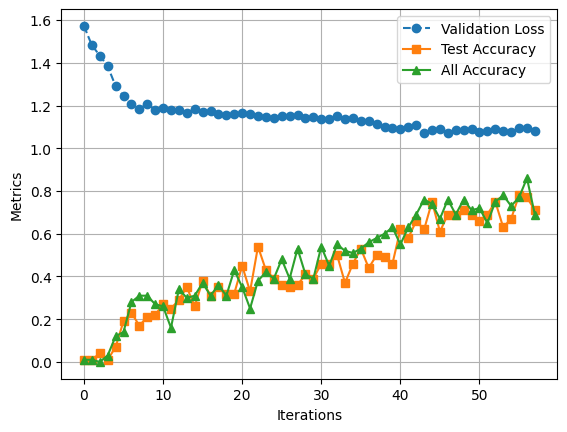

In [22]:


iterations = list(range(58))

plt.plot(iterations, val_loss_list, label="Validation Loss", linestyle="dashed", marker="o")
plt.plot(iterations, acc_test_list, label="Test Accuracy", linestyle="solid", marker="s")
plt.plot(iterations, acc_all_list, label="All Accuracy", linestyle="solid", marker="^")

plt.xlabel("Iterations")
plt.ylabel("Metrics")
plt.legend()
plt.grid(True)

In [32]:
fig = go.Figure()

iterations = list(range(58))

# Add lines
fig.add_trace(go.Scatter(x=iterations, y=val_loss_list, mode='lines+markers', name='Validation Loss'))
fig.add_trace(go.Scatter(x=iterations, y=acc_test_list, mode='lines+markers', name='Test Accuracy'))
fig.add_trace(go.Scatter(x=iterations, y=acc_all_list, mode='lines+markers', name='All Accuracy'))

# Set title label
fig.update_layout(
    title="Validation Loss & Accuracy over Iterations",
    xaxis_title="Iterations",
    yaxis_title="Metrics",
    legend_title="Metrics",
    width = 900,
    height = 500
)

fig.show()

wandb.init(project="transformer", name="val_loss and accuracy plot")
wandb.log({"Interactive Chart": wandb.Html(fig.to_html())})
wandb.finish()

In [ ]:
test_set = {1: test_1,
            2: test_12,
            3: test
            }

In [ ]:
def accuracy_print(model, num_digits, set_type):
        correct = 0
        if set_type == "all":
          for j in range(100):
              a = np.random.choice(np.arange(10**num_digits), 1)
              b = np.random.choice(np.arange(10**num_digits), 1)
              c = a + b
              input = f"{a.item()}+{b.item()}="
              context = torch.tensor(encode(input), dtype=torch.long, device=device)
              output = generate(model, context, 100, 1)
              if j // 10 == 0:
                  print(f"Input: {input}")
                  print(f"Output: {output}")
              if output == f"{a.item()}+{b.item()}={c.item()}":
                  correct += 1
        elif set_type == "test":
            for j in range(100):
                a = np.random.choice(test_set[num_digits], 1)
                b = np.random.choice(test_set[num_digits], 1)
                c = a + b
                input = f"{a.item()}+{b.item()}="
                context = torch.tensor(encode(input), dtype=torch.long, device=device)
                output = generate(model, context, 100, 1)
                if j // 10 == 0:
                    print(f"Input: {input}")
                    print(f"Output: {output}")
                if output == f"{a.item()}+{b.item()}={c.item()}":
                    correct += 1
        print(f"Accuracy for addition: {correct / 100} ")

In [ ]:
accuracy_print(model, 1, "all")

Input: 6+5=
Output: 6+5=11
Input: 5+4=
Output: 5+4=9
Input: 0+1=
Output: 0+1=11
Input: 9+8=
Output: 9+8=17
Input: 9+7=
Output: 9+7=16
Input: 4+6=
Output: 4+6=10
Input: 1+2=
Output: 1+2=3
Input: 3+7=
Output: 3+7=10
Input: 5+4=
Output: 5+4=9
Input: 6+8=
Output: 6+8=14
Accuracy for addition: 0.81 


In [ ]:
accuracy_print(model, 1, "test")

Input: 1+1=
Output: 1+1=
Input: 2+2=
Output: 2+2=8
Input: 2+1=
Output: 2+1=
Input: 2+1=
Output: 2+1=
Input: 1+1=
Output: 1+1=
Input: 1+1=
Output: 1+1=
Input: 2+1=
Output: 2+1=
Input: 2+1=
Output: 2+1=
Input: 1+1=
Output: 1+1=1
Input: 1+2=
Output: 1+2=3
Accuracy for addition: 0.14 


In [ ]:
accuracy_print(model, 2, "all")

Input: 75+76=
Output: 75+76=151
Input: 67+8=
Output: 67+8=75
Input: 1+68=
Output: 1+68=72
Input: 78+35=
Output: 78+35=113
Input: 35+53=
Output: 35+53=88
Input: 80+79=
Output: 80+79=159
Input: 38+4=
Output: 38+4=42
Input: 38+56=
Output: 38+56=93
Input: 45+95=
Output: 45+95=140
Input: 68+2=
Output: 68+2=70
Accuracy for addition: 0.92 


In [ ]:
accuracy_print(model, 2, "test")

Input: 28+89=
Output: 28+89=116
Input: 28+29=
Output: 28+29=57
Input: 29+1=
Output: 29+1=20
Input: 2+26=
Output: 2+26=28
Input: 46+26=
Output: 46+26=72
Input: 33+29=
Output: 33+29=62
Input: 26+49=
Output: 26+49=75
Input: 40+33=
Output: 40+33=73
Input: 78+87=
Output: 78+87=165
Input: 49+87=
Output: 49+87=136
Accuracy for addition: 0.83 


In [ ]:
accuracy_print(model, 3, "all")

Input: 836+723=
Output: 836+723=1559
Input: 640+226=
Output: 640+226=866
Input: 748+81=
Output: 748+81=829
Input: 396+664=
Output: 396+664=1060
Input: 580+857=
Output: 580+857=1437
Input: 519+626=
Output: 519+626=1155
Input: 136+729=
Output: 136+729=865
Input: 145+883=
Output: 145+883=1028
Input: 995+234=
Output: 995+234=1229
Input: 42+773=
Output: 42+773=815
Accuracy for addition: 0.87 


In [ ]:
accuracy_print(model, 3, "test")

Input: 519+84=
Output: 519+84=603
Input: 2+601=
Output: 2+601=207
Input: 812+315=
Output: 812+315=1137
Input: 999+590=
Output: 999+590=1589
Input: 690+294=
Output: 690+294=984
Input: 996+822=
Output: 996+822=1818
Input: 706+360=
Output: 706+360=1066
Input: 500+374=
Output: 500+374=874
Input: 709+865=
Output: 709+865=1574
Input: 614+353=
Output: 614+353=967
Accuracy for addition: 0.81 


In [ ]:
import subprocess

os.system('git config --global user.email "zifeibai@umich.edu"')
os.system('git config --global user.name "ZifeiBai"')

# 2️⃣ **Use Google Drive to store GitHub Token**
GITHUB_TOKEN_PATH = "/content/drive/MyDrive/URPS/github_token.txt"
if os.path.exists(GITHUB_TOKEN_PATH):
    with open(GITHUB_TOKEN_PATH, "r") as f:
        os.environ["GITHUB_TOKEN"] = f.read().strip()
else:
    print("❌ GitHub Token")
    exit(1)

# 3️⃣ **Set up GitHub remote repo**
GIT_PATH = "/content/drive/MyDrive/URPS/Git"
REPO_URL = f"https://{os.environ['GITHUB_TOKEN']}@github.com/ZifeiBai/URPS.git"

if not os.path.exists(GIT_PATH):
    print(f"📁 Creating directory: {GIT_PATH}")
    os.makedirs(GIT_PATH)

# 4️⃣ **If .git/ does not exsit， need to clone**
if not os.path.exists(os.path.join(GIT_PATH, ".git")):
    print("❌ Git repository not found. Cloning...")
    subprocess.run(f"rm -rf {GIT_PATH}", shell=True, check=True)
    subprocess.run(f"git clone {REPO_URL} {GIT_PATH}", shell=True, check=True)

# 5️⃣ **Enter Git repo**
os.chdir(GIT_PATH)
print("📂 Changed working directory to:", os.getcwd())


# 6️⃣ **Check Git status**
status_output = subprocess.run("git status", shell=True, capture_output=True, text=True)
print(status_output.stdout)

#  **Push to Git**
print("🚀 Adding files to Git...")
subprocess.run("git add .", shell=True, check=True)

print("📝 Committing changes...")
commit_output = subprocess.run('git commit -m "Auto update from Google Colab 2.6"', shell=True, capture_output=True, text=True)
print(commit_output.stdout)



print("📤 Pushing to GitHub...")
push_output = subprocess.run("git push origin main", shell=True, capture_output=True, text=True)
if "fatal" in push_output.stderr or "error:" in push_output.stderr:
    print("❌ Real Git Push Error:", push_output.stderr)
else:
    print("✅ Git Push Success!")

📂 Changed working directory to: /content/drive/MyDrive/URPS/Git
On branch main
Your branch is up to date with 'origin/main'.

Changes not staged for commit:
  (use "git add <file>..." to update what will be committed)
  (use "git restore <file>..." to discard changes in working directory)
	modified:   transformer.ipynb

no changes added to commit (use "git add" and/or "git commit -a")

🚀 Adding files to Git...
📝 Committing changes...
[main 8f41dda] Auto update from Google Colab 2.6
 1 file changed, 1 insertion(+), 1 deletion(-)
 rewrite transformer.ipynb (96%)

📤 Pushing to GitHub...
✅ Git Push Success!
